In [1]:
## THIS CELL IS DONE FOR YOU

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## Load the data
health_data=pd.read_csv('healthcare-dataset-stroke-data.csv') # csv file must be in the same directory as the notebook

# We need to perform some preprocessing to remove missing values and encode categorical variables
impute= SimpleImputer(missing_values=np.nan, strategy='median')
health_data['bmi']=pd.DataFrame(impute.fit_transform(np.array(health_data['bmi']).reshape(-1, 1)))
OH=OneHotEncoder()
for col in health_data.select_dtypes(include=['object']):
  health_data[col]=OH.fit_transform(health_data[[col]]).toarray()

# Separate the features and the target
X = health_data.drop('stroke', axis=1).values  # features
y = health_data['stroke'].values # targets

# Scale the features to have zero mean and unit variance -- this helps gradient descent converge faster
X = StandardScaler().fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train logistic regression classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Generate the predicted _probabilities_ on the test set
y_pred_probs = clf.predict_proba(X_test)[:, 1]  # probability of the positive class

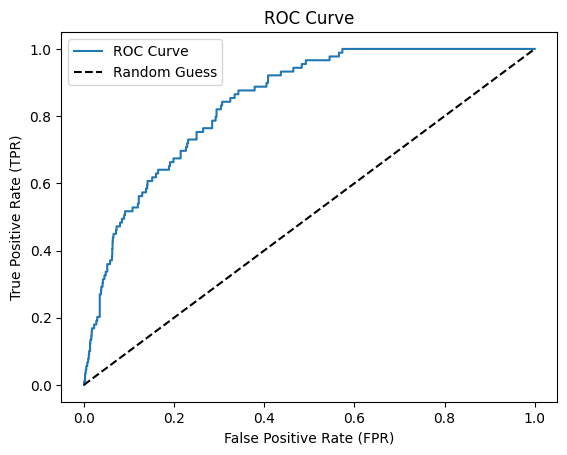

AUC: 0.8429689688443462


In [2]:
# ROC Curve construction and AUC calculation

# Function to compute TPR, FPR, TNR, FNR
def compute_rates(y_true, y_probs, threshold):
    """
    Compute tpr, fpr, tnr, and fnr for a single threshold value
    :param y_true: a vector of true labels (0 or 1)
    :param y_probs: a vector of predicted probabilities of the positive class
    :param threshold: a threshold value (scalar between 0 and 1)
    :return: a list whose elements are TPR, FPR, TNR, FNR
    """
    
    ## Compute the number of true positives, false positives, true negatives, and false negatives ##
    y_pred = (y_probs >= threshold).astype(int)
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    ## Compute the true positive rate (TPR), false positive rate (FPR), true negative rate (TNR), and false negative rate (FNR) ##
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
    TNR = TN / (TN + FP) if (TN + FP) > 0 else 0
    FNR = FN / (FN + TP) if (FN + TP) > 0 else 0

    ## return the list specified by the docstring ##
    return [TPR, FPR, TNR, FNR]

# Compute ROC Curve
def compute_roc_curve(y_true, y_probs):
    """
    Compute TPR and FPR for varying threshold values
    :param y_true: 
    :param y_probs: 
    :return: a typle of lists, where the first list contains the tpr values and the second list contains the fpr values
    """
    thresholds = np.sort(np.unique(y_probs))
    tpr_list, fpr_list = [], []
    
    ## Populate tpr_list and fpr_list here ##
    for threshold in thresholds:
        rates = compute_rates(y_true, y_probs, threshold)
        tpr_list.append(rates[0])  # TPR
        fpr_list.append(rates[1])  # FPR
    
    return tpr_list, fpr_list

## Call the compute_roc_curve function and store the results in tpr and fpr ##
tpr, fpr = compute_roc_curve(y_test, y_pred_probs)

## Plot ROC Curve ##
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Compute AUC using trapezoidal rule and print out the result ##
# Hint: you may have to sort the FPR values before computing the area under the curve
sorted_indices = np.argsort(fpr)
fpr_sorted = np.array(fpr)[sorted_indices]
tpr_sorted = np.array(tpr)[sorted_indices]
auc = np.trapezoid(tpr_sorted, fpr_sorted)
print("AUC:", auc)

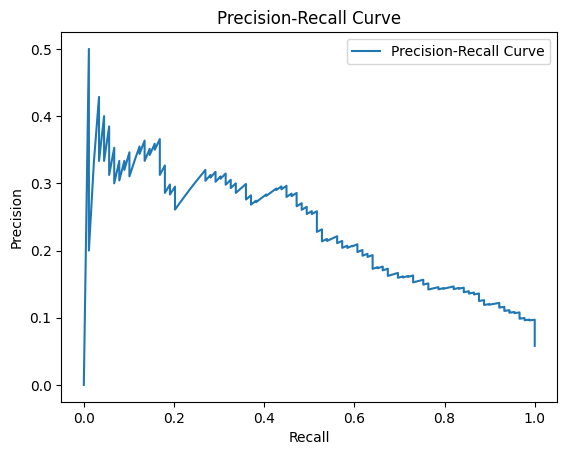

Average Precision: 0.23031682490596408


In [3]:
# Precision Recall Curve construction and Average Precision calculation

def compute_pr(y_true, y_probs, threshold):
    """
    Compute precision and recall for a single threshold value
    :param y_true: vector of true labels (0 or 1)
    :param y_probs: vector of predicted probabilities of the positive class
    :param threshold: a threshold value (scalar between 0 and 1)
    :return: a tuple containing the precision and recall values in first and second positions, respectively
    """
    
    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_probs >= threshold).astype(int)
    
    ## Compute precision ##
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    ## Compute recall ##
    FN = np.sum((y_true == 1) & (y_pred == 0))
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    return precision, recall

def compute_pr_curve(y_true, y_probs):
    """
    Compute precision and recall for varying threshold values
    :param y_true: vector of true labels (0 or 1)
    :param y_probs: vector of predicted probabilities of the positive class
    :return: a tuple of lists, where the first list contains the precision values and the second list contains the recall values
    """
    thresholds = np.sort(np.unique(y_probs))
    precision_list, recall_list = [], []

    ## populate precision_list and recall_list here ##
    for threshold in thresholds:
        precision, recall = compute_pr(y_true, y_probs, threshold)
        precision_list.append(precision)
        recall_list.append(recall)

    return precision_list, recall_list

## Call the compute_pr_curve function and store the results ##
precision, recall = compute_pr_curve(y_test, y_pred_probs)

## Plot Precision-Recall Curve ##
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

## Compute average precision and report the result ##
# Sort recall and corresponding precision values to calculate Average Precision correctly
sorted_indices = np.argsort(recall)
recall_sorted = np.array(recall)[sorted_indices]
precision_sorted = np.array(precision)[sorted_indices]

# Calculate the average precision using the trapezoidal rule
average_precision = np.trapezoid(precision_sorted, recall_sorted)
print("Average Precision:", average_precision)

In [4]:
# Compare your answers with the sklearn implementation

from sklearn.metrics import roc_auc_score, average_precision_score

## Call the roc_auc_score and average_precision_score functions from scikit-learn your data ##
roc_auc = roc_auc_score(y_test, y_pred_probs)
average_precision = average_precision_score(y_test, y_pred_probs)

## Print out the results ##
print("Scikit-Learn ROC AUC:", roc_auc)
print("Scikit-Learn Average Precision:", average_precision)

Scikit-Learn ROC AUC: 0.8429456254474151
Scikit-Learn Average Precision: 0.24013811340220162
